In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2
import os
import random
%matplotlib inline

In [2]:
from tensorflow import keras
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.src.layers import Dense, Input
from keras.src.layers import LSTM, Reshape
from keras.src.models import Sequential
from keras.src.layers import BatchNormalization, Activation
from keras.src.optimizers import Adam
from keras.src.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.src.utils import plot_model

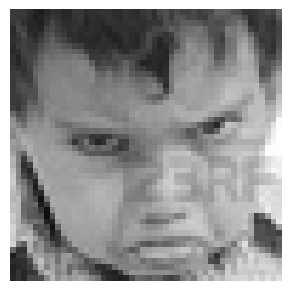

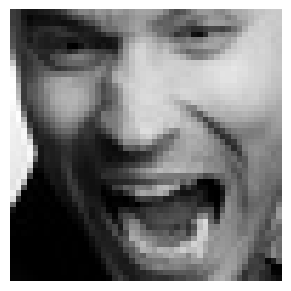

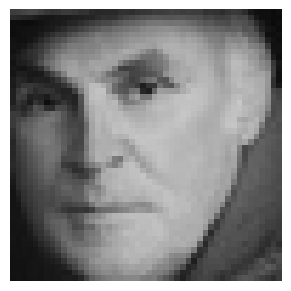

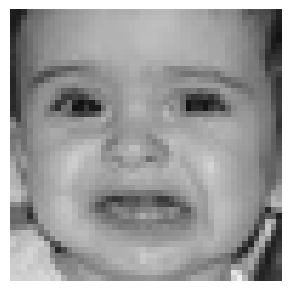

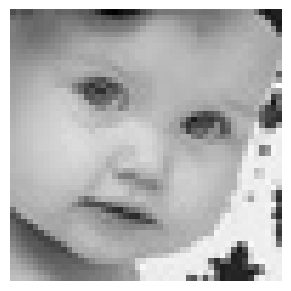

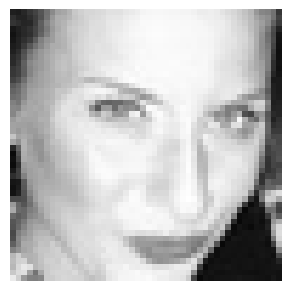

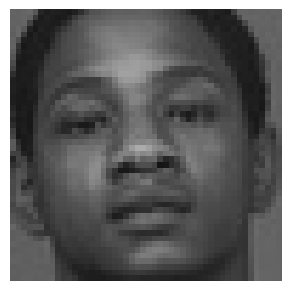

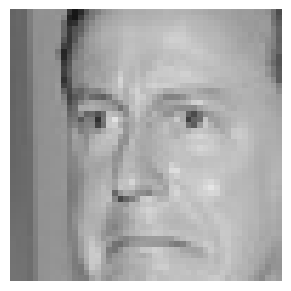

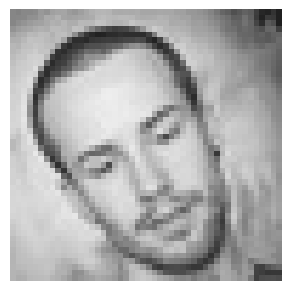

In [3]:
images = glob("train/**/**")
for i in range(9):
    image =random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [4]:
img_size = 48
batch_size = 64
sequence_length = 5

datagen_train = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = datagen_train.flow_from_directory('train/',
                                                    target_size=(img_size,img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)
datagen_validation = ImageDataGenerator(rescale=1./255)
validation_generator = datagen_validation.flow_from_directory('test/',
                                                              target_size=(img_size,img_size),
                                                              color_mode='grayscale',
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
def generate_sequence_data(generator, sequence_length):
    while True:
        batch_x, batch_y = next(generator)
        sequence_x = []
        sequence_y = []
        for i in range(len(batch_x)-sequence_length+1):
            sequence_x.append(batch_x[i:i+sequence_length])
            sequence_y.append(batch_y[i+sequence_length-1])
        yield np.array(sequence_x), np.array(sequence_y)

In [6]:
train_sequence_generator = generate_sequence_data(train_generator,sequence_length)
validation_sequence_generator = generate_sequence_data(validation_generator, sequence_length)

In [10]:
def create_sequential_model(input_shape, sequence_length):
    model = Sequential()
    
    model.add(Reshape((sequence_length, -1), input_shape=(sequence_length,) + input_shape))
    
    model.add(LSTM(units=64, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(LSTM(units=128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(LSTM(units=256, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(512, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return model

In [8]:
input_shape = (48, 48, 1)
sequence_length = 5

In [11]:
sequential_model = create_sequential_model(input_shape, sequence_length)
sequential_model.summary()

C:\Users\SHAIK\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 5, 2304)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 5, 64)          │       606,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 5, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,236,487 (4.72 MB)

 Trainable params: 1,235,591 (4.71 MB)

 Non-trainable params: 896 (3.50 KB)

In [10]:
epochs = 20
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
callbacks = [checkpoint, reduce_lr]

In [11]:
history = sequential_model.fit(train_sequence_generator,
                               steps_per_epoch=steps_per_epoch,
                               epochs=epochs,
                               validation_data = validation_sequence_generator,
                               validation_steps = validation_steps,
                               callbacks = callbacks)

Epoch 1/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.2184 - loss: 1.8571
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 430s 941ms/step - accuracy: 0.2185 - loss: 1.8570 - val_accuracy: 0.2366 - val_loss: 1.8320 - learning_rate: 0.0010
Epoch 2/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2678 - loss: 1.7774
Epoch 2: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 67s 150ms/step - accuracy: 0.2678 - loss: 1.7774 - val_accuracy: 0.1875 - val_loss: 1.8536 - learning_rate: 0.0010
Epoch 3/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2759 - loss: 1.7751
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 77s 173ms/step - accuracy: 0.2759 - loss: 1.7750 - val_accuracy: 0.1916 - val_loss: 1.8247 - learning_rate: 0.0010
Epoch 4/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2793 - loss: 1.7635
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━

In [12]:
batch_size = 64  
evaluation_steps = len(validation_generator)
evaluation_results = sequential_model.evaluate(validation_sequence_generator, steps=evaluation_steps, batch_size=batch_size)


113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.3199 - loss: 1.7021


In [13]:
model_json = sequential_model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)